In [146]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import interpolate
import math  
import sklearn.metrics 

In [153]:
file = "inp1.txt"
L, C, R, G, Rg, Rl, Cl, A, th, tr, t0, nz, dt, nt, sen, snap = np.loadtxt(file,dtype='double')
Lens=[.1,.2,.3,.4,.5,.6,.7,.8]
iter = 0

In [154]:
tt = np.arange(nt)*dt
condition = [np.logical_and((tt-t0)<tr,tt-t0>0), (tt-t0>=tr)]
value = [lambda x: A*(x-t0)/tr, A]
    

In [155]:
vs = np.piecewise(tt, condition, value)
#plt.plot(tt,vs)
#plt.show()
vs = np.pad(0.5*(vs[1:]+vs[:-1]),(0,1))

In [156]:
data=[]
iter = 0
for Lz in Lens:
    iter += 1
    nz = int(nz)
    nt = int(nt)
    #L = Rc/v
    #C = 1/(Rc*v)
    th = th-tr
    V = np.zeros(nz+1)
    I = np.zeros(nz)
    dz = Lz/nz
    sen = np.argmin(np.fabs(np.arange(nz+1)*dz-sen))

    ciself = (L/dt-R/2)/(L/dt+R/2)
    cvself = (C/dt-G/2)/(C/dt+G/2)
    ci = 1/((L/dt+R/2)*dz)
    cv = 1/((C/dt+G/2)*dz)

    cv0s = (C*dz/(2.0*dt)-1.0/(2.0*Rg))/(C*dz/(2.0*dt)+1.0/(2.0*Rg))
    cv0src = (1.0/Rg)/(C*dz/(2.0*dt)+1.0/(2.0*Rg))

    cv0i = 1.0/(C*dz/(2.0*dt)+1.0/(2.0*Rg))
    cvls = (1.0-(2.0*dt/(C*dz))*(1/(2.0*Rl) - Cl/dt))/(1.0+(2.0*dt/(C*dz))*(1/(2.0*Rl) + Cl/dt))
    cvli = (2.0*dt/(C*dz))/(1.0+(2.0*dt/(C*dz))*(1/(2.0*Rl) + Cl/dt))


    sens = np.zeros(nt)
    
    for it in range(nt):

        # if (it==snap):
        #     plt.plot(np.arange(nz+1)*dz,V)
        #     #plt.plot((0.5+np.arange(nz))*dz,I*Rc)
        #     plt.ylim(-1,1)
        #     plt.xlabel("z-position [m]")
        #     plt.ylabel("voltage [V]")
        #     plt.title("Voltage at t=%2.3f ns" %(1.0e9*it*dt))
        #     plt.savefig(file[:-4]+"time.png")
        #     #plt.show()
        #     plt.close()
        I = ciself*I-ci*(V[1:]-V[:-1])
        V[0] = cv0s*V[0] + cv0src*vs[it] - cv0i*I[0]
        V[1:-1] = cvself*V[1:-1] - cv*(I[1:]-I[:-1])
        V[-1] = cvls*V[-1] + cvli*I[-1]
        sens[it]=1.0*V[-1]
    

    #plt.plot((np.arange(nt))*dt,vs)
    # plt.plot((np.arange(0,nt))*dt,sens)
    data.append(sens)
    # plt.xlabel("time [s]")
    # plt.ylabel("Voltage [V]")
    # plt.title("Voltage at z = %3.3em" %(np.arange(nz+1)[sen]*dz))
    # #plt.savefig(f'{iter}position.png')
    # plt.show()
    # plt.close()

In [157]:
time = (np.arange(nt))*dt
initial_data=[]
for i in (0,4):
    my_tupple = (time,data[i])
    initial_data.append(my_tupple)


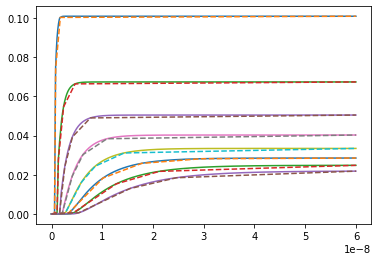

In [162]:
#piecewise model
initial_pwl_data=[]
for i in range(0,len(Lens)):
    
    x = time
    y = data[i]
    idx_all = []
    idx = np.argmin(x)
    idx_all.append(idx)
    idx = np.argmax(x)
    idx_all.append(idx)

    x_node = x [idx_all]
    y_node = y [idx_all]

    f = interpolate.interp1d(x_node, y_node)
    ypwl = f(x)

    ABS_error = abs(y - ypwl);
    mse = sklearn.metrics.mean_squared_error(y, ypwl)    
    rmse = math.sqrt(mse)

    while rmse>.001:

        idxx = np.argmax(ABS_error)
        idx_all.append(idxx)
        idx_all.sort()

        x_node = x [idx_all]
        y_node = y [idx_all]

        f = interpolate.interp1d(x_node, y_node)
        ypwl = f(x)
        ABS_error = abs(y - ypwl);
        mse = sklearn.metrics.mean_squared_error(y, ypwl)  
        rmse = math.sqrt(mse)    
    plt.plot(x,y,x,ypwl,'--')
    
    my_tupple2 = (x_node,y_node)
    initial_pwl_data.append(my_tupple2)

